# Look into detector submodules gaps - wide pixels

Let's consider only a single (top) detector module of Eiger(1) 1M at the BALDER beamline.

In [11]:
%reload_ext autoreload
%autoreload 2
#%matplotlib widget
if 'NOTEBOOK_INITIATED_FLAG' not in globals():
    NOTEBOOK_INITIATED_FLAG = True
    %cd ..

In [12]:
import os 
import numpy as np
import matplotlib.pyplot as plt

import examplesetup
import lib.utils as utils
#import lib.xtrace as xtrace

Load some data.

In [13]:
project_dir = '/data/visitors/balder/20220115/2022022408'
experiment_dir = os.path.join(project_dir, 'raw/XRD Eiger Test')
poni_dir = os.path.join(project_dir, 'process')

stacks = {
    "no_tilt_close": {
        "filename": 'LaB6_9_data_000001.h5',
        "poni": 'samuel_9_0.poni'
    },
}

data_layer = 9
saves = {}

for stack_name in stacks.keys():
    stack = stacks[stack_name]
    config, data = utils.load_stack(
        os.path.join(project_dir, experiment_dir, stack["filename"]),
        os.path.join(poni_dir, stack["poni"]),
    )
    img, mask = utils.mask(data[data_layer], False)
    saves[stack_name] = {
        "original_image": img,
    }

## Convert pyFAI calibration to Fit2D and bli711 notations

In [14]:
import os, json
# note: pyFAI is needed only for poni->Fit2D->bli711 calibration translation
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator

In [15]:
poni_fpath = os.path.join(poni_dir,stacks["no_tilt_close"]["poni"])

ai = AzimuthalIntegrator() # new integrator
ai.load(poni_fpath)

wlen = ai.get_wavelength() * 1e10 # (Å)
det_shape = ai.detector.shape

deg2rad = np.pi/180.
rad2deg = 180./np.pi

# convert detector parameters from pyFAI notation to bli711 (Fit2D-like) notation
pf2d = ai.getFit2D()
det_params = { 'n0': pf2d['centerY'], 'm0': pf2d['centerX'], \
               'wn': (pf2d['pixelY']*1e-3/pf2d['directDist']), 'wm': (pf2d['pixelX']*1e-3/pf2d['directDist']), \
               'phi': 0*np.pi/2, \
               'n': det_shape[0], 'm': det_shape[1], \
               'rot': pf2d['tiltPlanRotation']*deg2rad , 'tilt': pf2d['tilt']*deg2rad }

print("--- bli711 notation ---")
print(det_params)

# store the bli711 notation in json format
#with open(os.path.join(project_dir,'analysis','XRD','calib2nd_day.pdet.json'), 'w') as f:
#    f.write(json.dumps(det_params))

--- bli711 notation ---
{'n0': 327.3716514708977, 'm0': 1157.0957312452545, 'wn': 0.0009323469973413614, 'wm': 0.0009323469973413614, 'phi': 0.0, 'n': 1065, 'm': 1030, 'rot': 0.0, 'tilt': 0.0}


### Description:

```
{ 'n0': 327.3716514708977, 'm0': 1157.0957312452545, 'wn': 0.0009323469973413614, ... }
```

In *bli711* notation:

    - n0 ... beam center (row index) ... the origin is in the first pixel corner !!!
    - m0 ... beam center (col index) ... the origin is in the first pixel corner !!!
    - wn ... angular size of a pixel (rad): wn = 75 um / dsitance (um) = 75/0.08044215320461867e9

### Calculation of the 2Theta angle for a each pixel

In [16]:
# tth = tth2Dsimple(delta,N,M,params) - calculate diffraction 2Theta (rad)
#     for (N,M) matrices of pixels for a 2D detector rotated by angle
#     delta. Detector parameters are stored in the associative array:
#     
#     params = { 'n0': 0, 'm0': 0, 'wn': width(n)/L, 'wm': width(m)/L, 'phi': 0. }
def tth2Dsimple(N,M,params,delta=0.):
    # get parameters
    n0 = params['n0'] # n0 - detector zero
    m0 = params['m0'] # m0 - detector zero
    wn = params['wn'] # wn/L
    wm = params['wm'] # wm/L
    phi = params['phi'] # rotation around detector axis (optimize)
    # calculate pixel coordinates in the lab ref. system
    # apply detector phi-rotation
    c = np.cos(phi)
    s = np.sin(phi)
    tN = c*(N-n0)*wn - s*(M-m0)*wm
    tM = s*(N-n0)*wn + c*(M-m0)*wm
    # main axis rotation
    c = np.cos(delta)
    s = np.sin(delta)
    X = c - s*tN
    Y = s + c*tN
    Z = tM
    R = np.sqrt( X**2 + Y**2 + Z**2 )
    tth = np.arccos(X/R)
    chi = np.arctan2(Y,Z)
    return tth, chi

Similar but including tilt.

In [17]:
# R = rotMatrix(theta, axis) - matrix representing clockwise rotation around
#                              the given axis by angle theta (in radians)
def rotMatrix(theta=0.0, axis=[0,0,1]):
    # normailsed axis coordinates
    w = np.array(axis)
    w = w/np.linalg.norm(w)
    # Rodrigues' rotation matrix
    Om = np.array([[0,-w[2],w[1]],[w[2],0,-w[0]],[-w[1],w[0],0]])
    R = np.eye(3) + Om * np.sin(theta) + np.dot(Om,Om) * (1.-np.cos(theta))
    return R

# R = rotMatrixFit2D(theta, axis) - matrix representing detector tilt with
#                                   respect to direct beam with Fit2D notation
def tiltMatrixFit2D(rot,tilt):
    axis = np.array([0,-np.cos(rot),np.sin(rot)])
    R = rotMatrix(-tilt,axis)
    return R

# tth = tth2Dwithtilt(delta,N,M,params) - calculate diffraction 2Theta (rad)
#     for (N,M) matrices of pixels for a 2D detector rotated by angle
#     delta. Detector parameters are stored in the associative array:
#     
#     params = { 'n0': 0, 'm0': 0, 'wn': width(n)/L, 'wm': width(m)/L, 'phi': 0., 'rot': 0., 'tilt': 0. }
def tth2DwithTilt(delta,N,M,params):
    # get parameters
    n0 = params['n0'] # n0 - detector zero
    m0 = params['m0'] # m0 - detector zero
    wn = params['wn'] # wn/L
    wm = params['wm'] # wm/L
    phi = params['phi'] # rotation around detector axis (optimize)
    rot  = params['rot'] # Fit2D tilt-plane rotation parameter
    tilt = params['tilt'] # Fit2D detector tilt
    # calculate pixel coordinates in the lab ref. system
    # apply detector phi-rotation
    c = np.cos(phi)
    s = np.sin(phi)
    tN = c*(N-n0)*wn - s*(M-m0)*wm
    tM = s*(N-n0)*wn + c*(M-m0)*wm
    # apply detector tilt
    W = tiltMatrixFit2D(rot,tilt)
    tX = W[0,1]*tN + W[0,2]*tM + 1. # including distance of beam center on the detector from the sample
    tY = W[1,1]*tN + W[1,2]*tM
    tZ = W[2,1]*tN + W[2,2]*tM
    # note: up to now the rotation matrix is constant
    # i.e. can be saved and does not need to be recalculated every time (optimize)
    # main axis rotation
    c = np.cos(delta)
    s = np.sin(delta)
    X = c*tX - s*tY
    Y = s*tX + c*tY
    Z = tZ
    # calculate 2Theta
    R = np.sqrt( X**2 + Y**2 + Z**2 )
    tth = np.arccos(X/R)
    chi = np.arctan2(Y,X)
    return tth, chi

In [18]:
N = np.arange(0,det_params['n'],1,int)
M = np.arange(0,det_params['m'],1,int)
M,N = np.meshgrid(M,N) # image notation
# get tth, chi
delta= 0.0
TTH, CHI = tth2DwithTilt(delta,N,M,det_params)

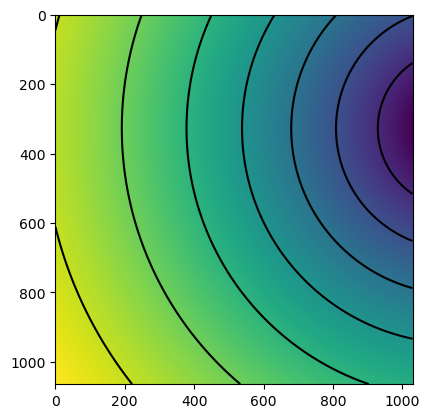

In [19]:
plt.imshow(TTH*rad2deg, origin='upper')
plt.contour(M, N, TTH*rad2deg, origin='upper', colors='k');

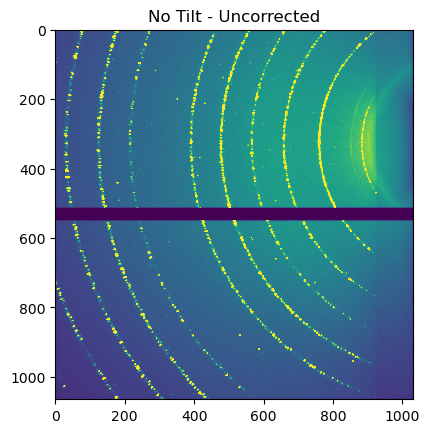

In [20]:
info = {'source': 'no_tilt_close',
        'image': 'original_image',
        'area': (slice(0,None), slice(0,None))
       }

im = saves[info["source"]][info["image"]][info["area"]]

perc = np.percentile(im, 99)

# full size image
plt.imshow(im, vmax=perc)
plt.title("No Tilt - Uncorrected");